# Cityscapes project

### Objective: segment the cities images to be able to identify the sky portion in them.
### By: Christian Pala and Manuel Ippolito
### Class: D3A

#### Import the libraries used:

In [54]:
# Import Libraries:
# Data manipulation:
from glob import glob
import os
from pathlib import Path
import shutil
import numpy as np
import warnings
import os
import numpy as np
import pandas as pd

# Date and time
from datetime import datetime

# Randomness:
from random import randint

# Metrics:
from sklearn.metrics import roc_auc_score

# Plotting:
import matplotlib.pyplot as plt
import skimage

# Progress bar:
from tqdm import tqdm

# Modelling:
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


# Typings
from typing import Union

# Tensorboard:
import tensorflow as tf
from tensorboard import program

In [55]:
# Todo: Check why keras improts are causing troubles
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Reshape

AttributeError: module 'tensorflow.compat.v2.__internal__' has no attribute 'register_load_context_function'

#### Define constants, Paths to the initial dataset folders, and tensorboard logs path

In [51]:
# Get the project root path, which is the parent directory of the current file
ROOT_PATH = os.path.dirname(os.path.abspath('')) # Todo: Check with Chri if it is correct to remove __file__ and substitute it with ''
# Results folder:
RESULTS_PATH = os.path.join(ROOT_PATH, 'results')
# Sample image results folder:
SAMPLE_IMAGE_RESULTS_PATH = os.path.join(RESULTS_PATH, 'sample_images')
# Tensorboard logs folder:
TENSORBOARD_LOGS_PATH = os.path.join(RESULTS_PATH, 'tensorboard_logs')

# Ensure the directory exists:
Path(SAMPLE_IMAGE_RESULTS_PATH).mkdir(parents=True, exist_ok=True)
log_path = Path(TENSORBOARD_LOGS_PATH, datetime.now().strftime("%Y%m%d-%H%M%S"))
log_path.mkdir(parents=True, exist_ok=True)

# Tensorflow logging level:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [52]:
# Define the paths to the initial dataset folders:
# get the path to the leftImg8bit folder
LEFT_IMG_8_BIT_PATH = os.path.join(ROOT_PATH, "leftImg8bit")
# get the path to the gtFine folder
GT_FINE_PATH = os.path.join(ROOT_PATH, "gtFine")
# get the path of the initial dataset
INITIAL_DATASET_PATH = os.path.join(ROOT_PATH, 'initial_dataset')
# get the path of the training dataset
TRAINING_DATASET_PATH = os.path.join(INITIAL_DATASET_PATH, 'train')
# get the path of the validation dataset
VALIDATION_DATASET_PATH = os.path.join(INITIAL_DATASET_PATH, 'val')
# get the path of the testing dataset
TESTING_DATASET_PATH = os.path.join(INITIAL_DATASET_PATH, 'test')
# Training city:
# We will use the city of Aachen for our training dataset
TRAINING_CITY = "aachen"
# We will use the city of Frankfurt for our validation dataset
VALIDATION_CITY = "frankfurt"
# We will use the city of Zürich for our testing dataset
TESTING_CITY = "zurich"

# Define constants:
# Patch size:
PATCH_SIZE = 256

### Pre-processing phase

The dataset we used is the following:

- the Training set is made of 174 images from Aachen,
- the Validation set is made of 99 images from Frankfurt,
- the Testing set is made of 121 images from Zurich.

#### Create the initial dataset folders:

Define utility functions to create the initial dataset:

In [3]:
def is_populated(path: Path) -> bool:
    """
    Checks if the folder is already populated
    @param path: the path to check
    :return: bool: whether the folder is populated or not
    """
    return len(list(path.iterdir())) != 0


def create_initial_dataset_folder_with_images_and_masks(city: str, train: bool = True, val_city: str = None) \
        -> None:
    """
    Creates the initial dataset folder with the images from the given city
    @param city: the city to use, must be present in the dataset, we selected Aachen and Zurich for
    our training and testing datasets respectively.
    @param train: bool: default (True) whether we are creating the training dataset or the testing dataset.
    @param val_city: str: if the validation dataset is to be created, the city to use for the validation dataset.
    :return: None. Populates the initial dataset folder with the images and masks from the given city
    """

    # Select the path where the images and masks will be copied to, depending on whether we are creating
    # the training dataset or the testing dataset
    im_path = Path(INITIAL_DATASET_PATH, "train") if train else Path(INITIAL_DATASET_PATH, "test")
    im_path.mkdir(parents=True, exist_ok=True)

    # We will use the city of Aachen for our training dataset and the city of Zürich for our testing dataset
    # both are present in the training dataset
    sub_folder = "train"

    # if the folder is already populated, delete it and create a new one:
    if is_populated(im_path):
        shutil.rmtree(im_path)
        im_path.mkdir(parents=True, exist_ok=True)

    # Copy the training or testing images to the initial dataset folder:
    for image_path in glob(str(Path(LEFT_IMG_8_BIT_PATH, sub_folder, city, "*.png"))):
        shutil.copy(str(image_path), str(im_path))

    # Copy the training or testing masks to the initial dataset folder:
    for image_path in glob(str(Path(GT_FINE_PATH, sub_folder, city, "*color.png"))):
        shutil.copy(str(image_path), str(im_path))

    # if a validation city is provided, we create the validation dataset:
    if val_city:
        sub_folder = "val"
        val_path = Path(INITIAL_DATASET_PATH, "val")
        val_path.mkdir(exist_ok=True, parents=True)

        # if the folder is already populated, delete it and create a new one:
        if is_populated(val_path):
            shutil.rmtree(val_path)
            val_path.mkdir(parents=True, exist_ok=True)

        # We only need the first 100 images from the validation dataset:
        for i, image_path in enumerate(glob(str(Path(LEFT_IMG_8_BIT_PATH, sub_folder, val_city, "*.png")))):
            if i < 100:
                shutil.copy(str(image_path), str(val_path))

        for i, image_path in enumerate(glob(str(Path(GT_FINE_PATH, sub_folder, val_city, "*color.png")))):
            if i < 100:
                shutil.copy(str(image_path), str(val_path))


def rename_images_and_masks(train: bool = True, val: bool = True) -> None:
    """
    Renames the images and masks to a more succinct format:
    @param train: whether we are renaming the training dataset or the testing dataset.
    @param val: whether we are renaming the validation dataset or not.
    :return: None. Renames the images and masks
    """
    im_path = Path(INITIAL_DATASET_PATH, "train") if train else Path(INITIAL_DATASET_PATH, "test")

    # Rename the images and masks:
    for i, image_path in enumerate(glob(str(im_path / "*leftImg8bit.png"))):
        # rename the image
        Path(image_path).rename(im_path / f"image_{i}.png")
    # rename the mask
    for i, image_path in enumerate(glob(str(im_path / "*color.png"))):
        # rename the mask
        Path(image_path).rename(im_path / f"mask_{i}.png")

    # rename the validation images and masks:
    if val:
        im_path = Path(INITIAL_DATASET_PATH, "val")

        for i, image_path in enumerate(glob(str(im_path / "*leftImg8bit.png"))):
            # rename the image
            Path(image_path).rename(im_path / f"image_{i}.png")

        for i, image_path in enumerate(glob(str(im_path / "*color.png"))):
            # rename the mask
            Path(image_path).rename(im_path / f"mask_{i}.png")

Create the initial dataset folders

In [ ]:
# Create the initial dataset folders
create_initial_dataset_folder_with_images_and_masks(city=TRAINING_CITY, val_city=VALIDATION_CITY)
create_initial_dataset_folder_with_images_and_masks(city=TESTING_CITY, train=False)
rename_images_and_masks(train=True, val=True)
rename_images_and_masks(train=False)

#### Create the binary masks for identifying sky pixels and save them:

Utility functions for images visualization and binary mask creation:

In [17]:
def count_number_of_files(path: Union[Path, str]) -> int:
    """
    Counts the number of files in a directory
    @param path: the path to the directory
    :return: the number of files in the directory
    """
    return len(glob(os.path.join(path, '*image_*.png')))


def get_image_and_segmentation(img_number: Union[str, int], train: bool = True) \
        -> (np.ndarray, np.ndarray):
    """
    Gets the image corresponding to the given number and its full segmentation.
    @param: img_number: Index of the image desired to be plotted
    @param: train: True if the image is from the training dataset, False if it is from the testing dataset
    :return image and segmentation as numpy ndarrays.
    """
    # Check that the given image number is a string
    img_number = str(img_number)

    im_path = str(Path(TRAINING_DATASET_PATH, 'image_' + img_number + '.png')) \
        if train else str(Path(TESTING_DATASET_PATH, 'image_' + img_number + '.png'))
    segmentation_path = str(Path(TRAINING_DATASET_PATH, 'mask_' + img_number + '.png')) \
        if train else str(Path(TESTING_DATASET_PATH, 'mask_' + img_number + '.png'))

    # Get the actual image and segmentation as numpy ndarrays
    im = skimage.io.imread(im_path)
    segmentation = skimage.io.imread(segmentation_path)
    return im, segmentation


def get_image_and_segmentation_for_validation(img_number: Union[str, int]) \
        -> (np.ndarray, np.ndarray):
    """
    Gets the image corresponding to the given number and its full segmentation.
    @param img_number: the index of the image desired to be plotted
    @return: image and segmentation as numpy ndarrays.
    """
    # Check that the given image number is a string
    img_number = str(img_number)

    im_path = str(Path(VALIDATION_DATASET_PATH, 'image_' + img_number + '.png'))
    segmentation_path = str(Path(VALIDATION_DATASET_PATH, 'mask_' + img_number + '.png'))
    im = skimage.io.imread(im_path)
    segmentation = skimage.io.imread(segmentation_path)

    return im, segmentation


def get_binary_mask(img_number: Union[str, int], train: bool = True) -> np.ndarray:
    """
    Gets the binary mask corresponding to the given number
    @param img_number: the index of the image desired to be plotted
    @param train: True if the image is from the training dataset, False if it is from the testing dataset
    :return: the binary mask as a numpy ndarray
    """
    # The binary mask is in the same folder as the image and segmentation named as binary_mask_sky_{img_number}.png
    path = TRAINING_DATASET_PATH if train else TESTING_DATASET_PATH
    binary_mask_path = str(Path(path, 'binary_mask_sky_' + str(img_number) + '.png'))
    binary_mask = skimage.io.imread(binary_mask_path)
    return binary_mask


def visualize_image_and_segmentation(img_number: Union[str, int] = 1, train: bool = True,
                                     im: np.ndarray = None, segmentation: np.ndarray = None) -> None:
    """
    Plots side-by-side the image corresponding to the given number and its full segmentation.
    @param: img_number: Index of the image desired to be plotted.
    :return: None. It plots directly the corresponding images.
    """
    # Get the actual image and segmentation as numpy ndarrays
    if (im is None) and (segmentation is None):
        im, segmentation = get_image_and_segmentation(img_number, train)

    # Plot the image and its segmentation side-by-side
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)
    ax0.set_title('Original image')
    ax0.xaxis.set_visible(False)
    ax0.yaxis.set_visible(False)
    ax0.imshow(im, vmin=0, vmax=255)

    ax1.set_title('Image Segmentation')
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.imshow(segmentation, vmin=0, vmax=255)
    fig.show()


def remove_alpha_channel(image: np.ndarray) -> np.ndarray:
    """
    Removes the alpha channel from the image
    @param image: the image to remove the alpha channel from
    :return: the image without the alpha channel
    """
    if image.shape[-1] == 4:
        return image[..., :3]
    else:
        return image


def binary_mask(mask) -> np.ndarray:
    """
    Converts the mask to a binary mask, keeping only the sky class as 1 and the rest as 0
    @param: param mask: the mask to convert
    :return: the binary mask
    """
    # from the docs, sky has the following RGB values: 70,130,180.
    # we noticed the images are saved with 4 channels, so we need to ignore the alpha channel.
    # https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

    # Remove the alpha channel from the segmentation image
    mask = remove_alpha_channel(mask)

    # Compute the sky mask: 70, 130, 180
    sky = ((mask[:, :, 0] == 70) & (mask[:, :, 1] == 130) & (mask[:, :, 2] == 180))

    # set to 1 the sky pixels and 0 the rest, ignoring the alpha channel.
    mask[sky, :] = 255
    mask[~sky, :] = 0
    return mask


def save_binary_mask_images(label: str = 'sky', train: bool = True, val: bool = True) -> None:
    """
    Saves the binary mask images
    @param: label: The label of the element that is wanted to be selected.
    @param: train: Flag to define whether the binary masks are for training or testing.
    @param: val: Flag to define whether we have a validation set or not.
    :return: None. It directly saves the images in the desired path.
    """
    if train:
        n_images = count_number_of_files(TRAINING_DATASET_PATH)
        imgs_path = Path(TRAINING_DATASET_PATH, f'binary_mask_{label}_')
        [skimage.io.imsave(fname=f'{imgs_path}{i}.png', arr=binary_mask(get_image_and_segmentation(i, train=True)[1]))
         for i in range(n_images)]
        if val:
            n_images = count_number_of_files(VALIDATION_DATASET_PATH)
            imgs_path = Path(VALIDATION_DATASET_PATH, f'binary_mask_{label}_')
            [skimage.io.imsave(fname=f'{imgs_path}{i}.png', arr=binary_mask(get_image_and_segmentation_for_validation(i)[1]))
             for i in range(n_images)]

    else:
        n_images = count_number_of_files(TESTING_DATASET_PATH)
        imgs_path = Path(TESTING_DATASET_PATH, f'binary_mask_{label}_')
        [skimage.io.imsave(fname=f'{imgs_path}{i}.png',
                           arr=binary_mask(get_image_and_segmentation(i, train=False)[1]))
         for i in range(n_images)]


def sample_random_images(train: bool = True) -> None:
    """
    Samples 3 random images from the training, validation and testing sets
    together with their segmentation and binary masks to visually check that
    the data is correct.
    @return: None. It directly plots the images.
    """
    if train:
        # Sample 3 random images from the training set
        print("3 images from the testing set (Aachen):")
        train_imgs = np.random.randint(0, count_number_of_files(TRAINING_DATASET_PATH), 3)
        for i in train_imgs:
            image = get_image_and_segmentation(i, train=True)[0]
            segmentation = get_image_and_segmentation(i, train=True)[1]
            binary_mask = get_binary_mask(i, train=True)
            fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3)
            ax0.set_title('Original image')
            ax0.xaxis.set_visible(False)
            ax0.yaxis.set_visible(False)
            ax0.imshow(image, vmin=0, vmax=255)

            ax1.set_title('Image Segmentation')
            ax1.xaxis.set_visible(False)
            ax1.yaxis.set_visible(False)
            ax1.imshow(segmentation, vmin=0, vmax=255)

            ax2.set_title('Binary Mask')
            ax2.xaxis.set_visible(False)
            ax2.yaxis.set_visible(False)
            ax2.imshow(binary_mask, vmin=0, vmax=255)
            fig.show()
    else:
        # Sample 3 random images from the testing set
        print("3 images from the testing set (Zurich):")
        test_imgs = np.random.randint(0, count_number_of_files(TESTING_DATASET_PATH), 3)
        for i in test_imgs:
            image = get_image_and_segmentation(i, train=False)[0]
            segmentation = get_image_and_segmentation(i, train=False)[1]
            binary_mask = get_binary_mask(i, train=False)
            fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3)
            ax0.set_title('Original image')
            ax0.xaxis.set_visible(False)
            ax0.yaxis.set_visible(False)
            ax0.imshow(image, vmin=0, vmax=255)

            ax1.set_title('Image Segmentation')
            ax1.xaxis.set_visible(False)
            ax1.yaxis.set_visible(False)
            ax1.imshow(segmentation, vmin=0, vmax=255)

            ax2.set_title('Binary Mask')
            ax2.xaxis.set_visible(False)
            ax2.yaxis.set_visible(False)
            ax2.imshow(binary_mask, vmin=0, vmax=255)
            fig.show()

Create and save the binary masks for identifying sky pixels

In [ ]:
# Create and save the binary masks for identifying sky pixels
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    save_binary_mask_images(label='sky', train=True, val=True)
    save_binary_mask_images(label='sky', train=False)

#### For each city (set) we matched the original images with their full segmentation and binary mask for the sky.

#### Below some examples:

3 images from the testing set (Aachen):


C:\Users\manue\AppData\Local\Temp\ipykernel_10792\208793019.py:180: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


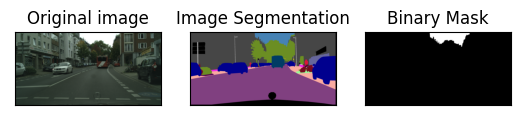

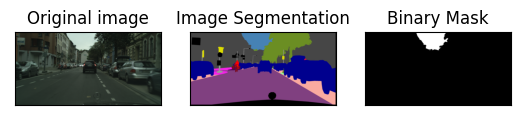

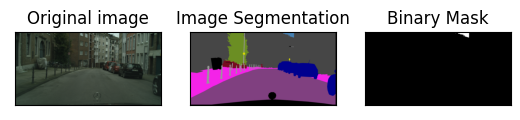

In [18]:
# Sample and plot 3 images from the training set 
# Visualize them together with thier full segmentation and binary mask for sky pixel identification 
sample_random_images(train=True)

3 images from the testing set (Zurich):


C:\Users\manue\AppData\Local\Temp\ipykernel_10792\208793019.py:204: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


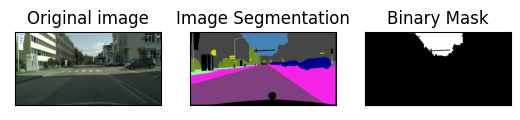

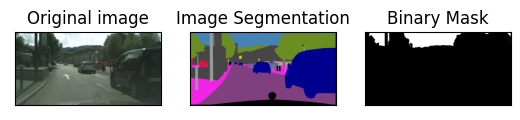

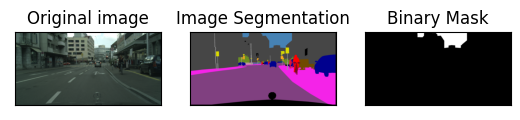

In [19]:
# Sample and plot 3 images from the testing set 
# Visualize them together with thier full segmentation and binary mask for sky pixel identification 
sample_random_images(train=False)

#### Create two balanced datasets, respectively one having pixels and one having patches:

Utility functions for pixels and patches sampling,
used to create the 2 datasets containing respectively pixels and patches:

In [24]:
def get_images_and_binary_masks(train: bool = True) -> (list, list):
    """
    Auxiliary function to get the images and the binary masks from the dataset.
    @param train: bool: True if the image is from the training dataset, False if it is from the testing dataset
    :return:
    """
    # get the correct path:
    path = TRAINING_DATASET_PATH if train else TESTING_DATASET_PATH

    # get all the images:
    images = []
    for image_path in glob(os.path.join(path, 'image_*.png')):
        images.append(skimage.io.imread(image_path))

    # get all the grayscale binary masks in the path:
    binary_masks = []
    for mask_path in glob(os.path.join(path, 'binary_mask_*.png')):
        binary_masks.append(skimage.io.imread(mask_path))
    # cast the binary mask to grayscale
    binary_masks = [skimage.color.rgb2gray(mask) for mask in binary_masks]

    return images, binary_masks


def get_val_images_and_binary_masks() -> (list, list):
    """
    Auxiliary function to get the images and the binary masks from the validation dataset.
    :return: the images and the binary masks from the validation dataset.
    """
    # get the correct path:
    path = VALIDATION_DATASET_PATH

    # get all the images:
    images = []
    for image_path in glob(os.path.join(path, 'image_*.png')):
        images.append(skimage.io.imread(image_path))

    # get all the grayscale binary masks in the path:
    binary_masks = []
    for mask_path in glob(os.path.join(path, 'binary_mask_*.png')):
        binary_masks.append(skimage.io.imread(mask_path))

    binary_masks = [skimage.color.rgb2gray(mask) for mask in binary_masks]

    return images, binary_masks


def compute_validation_proportions() -> (int, int):
    """
    Computes the total number of pixels in the sky class in the validation dataset
    :return: the total number of pixels in the sky class and the total number of pixels in the non-sky class
    for the validation dataset.
    """
    # get the binary masks:
    binary_masks = get_val_images_and_binary_masks()[1]

    # compute the total number of pixels in the sky class
    total_sky_pixels = 0
    total_non_sky_pixels = 0
    for mask in binary_masks:
        total_sky_pixels += np.sum(mask == 1)
        total_non_sky_pixels += np.sum(mask != 1)

    # compute the sampling proportions to sample for each images
    return total_sky_pixels, total_non_sky_pixels


def validation_pixel_sampler(total_count: int) -> pd.DataFrame:
    """
    Sample pixels from the validation dataset.
    @param total_count: the total number of pixels to sample.
    :return: None. Saves the sampled pixels in a csv file.
    """
    # get the images and the binary masks:
    images, binary_masks = get_val_images_and_binary_masks()

    # compute the sampling proportions:
    total_sky_pixels, total_non_sky_pixels = compute_validation_proportions()

    sky_sample = total_count / total_sky_pixels
    non_sky_sample = total_count / total_non_sky_pixels

    # create the dataset
    df = pd.DataFrame(columns=['image_nr', 'r', 'g', 'b', 'x', 'y', 'class'])

    # sample the pixels
    image_count = 0
    for image, mask in zip(images, binary_masks):
        sky_row, sky_column, sky_r, sky_g, sky_b, non_sky_row, non_sky_column, non_sky_r, non_sky_g, non_sky_b = \
            binary_sampler(image, mask, sky_sample, non_sky_sample)

        # create the sky dataframe
        sky_df = pd.DataFrame(
            {'image_nr': image_count, 'r': sky_r, 'g': sky_g, 'b': sky_b, 'x': sky_column, 'y': sky_row, 'class': 1})

        # create the non-sky dataframe
        non_sky_df = pd.DataFrame(
            {'image_nr': image_count, 'r': non_sky_r, 'g': non_sky_g, 'b': non_sky_b, 'x': non_sky_column,
             'y': non_sky_row, 'class': 0})

        # concatenate the dataframes
        df = pd.concat([df, sky_df, non_sky_df], ignore_index=True)

        # increment the image count
        image_count += 1

    return df


def compute_sampling_proportions(train: bool = True) -> (int, int):
    """
    Computes the total number of pixels in the sky class in the training dataset
    @param train: True if the image is from the training dataset, False if it is from the testing dataset
    :return: the total number of pixels in the sky class
    """
    # get the binary masks:
    binary_masks = get_images_and_binary_masks(train=train)[1]

    # compute the total number of pixels in the sky class
    total_sky_pixels = 0
    total_non_sky_pixels = 0
    for mask in binary_masks:
        total_sky_pixels += np.sum(mask == 1)
        total_non_sky_pixels += np.sum(mask != 1)

    # compute the sampling proportions to sample for each images
    return total_sky_pixels, total_non_sky_pixels


def binary_sampler(image: np.ndarray, binary_mask: np.ndarray, sky_fraction: float, non_sky_fraction: float) \
        -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray,
            np.ndarray, np.ndarray):
    """
    Samples the rows, columns, and rgb values of an image for the sky and non-sky classes.
    @param image: np.ndarray: the image to sample
    @param binary_mask: np.ndarray: the binary mask of the image
    @param sky_fraction: float: the fraction of the sky pixels to sample
    @param non_sky_fraction: float: the fraction of the non-sky pixels to sample
    :return: the rows, columns, and rgb values of the sampled pixels for the sky and non-sky classes.
    """
    sky_pixels = np.argwhere(binary_mask == 1)
    # select the row index of the sky pixels
    sky_row = sky_pixels[:, 0]
    # select the column index of the sky pixels
    sky_column = sky_pixels[:, 1]
    # create tuples of the row and column index of the sky pixels
    sky_pixels = list(zip(sky_row, sky_column))
    # sample the sky pixels
    sky_pixels_index = np.random.choice(len(sky_pixels), int(len(sky_pixels) * sky_fraction), replace=False)
    sky_pixels = [sky_pixels[i] for i in sky_pixels_index]
    # get the row and column index of the sky pixels
    sky_row = [pixel[0] for pixel in sky_pixels]
    sky_column = [pixel[1] for pixel in sky_pixels]
    # get the r, g, b values of the sampled pixels
    sky_r = image[sky_row, sky_column, 0]
    sky_g = image[sky_row, sky_column, 1]
    sky_b = image[sky_row, sky_column, 2]

    # get the non-sky pixels
    non_sky_pixels = np.argwhere(binary_mask == 0)
    # select the row index of the non-sky pixels
    non_sky_row = non_sky_pixels[:, 0]
    # select the column index of the non-sky pixels
    non_sky_column = non_sky_pixels[:, 1]
    # create tuples of the x and y index of the non-sky pixels
    non_sky_pixels = list(zip(non_sky_row, non_sky_column))
    # sample the non-sky pixels
    non_sky_pixels_index = np.random.choice(len(non_sky_pixels), int(len(non_sky_pixels) * non_sky_fraction),
                                            replace=False)
    non_sky_pixels = [non_sky_pixels[i] for i in non_sky_pixels_index]
    # get the row and column index of the non-sky pixels
    non_sky_row = [pixel[0] for pixel in non_sky_pixels]
    non_sky_column = [pixel[1] for pixel in non_sky_pixels]
    # get the r, g, b values of the sampled pixels
    non_sky_r = image[non_sky_row, non_sky_column, 0]
    non_sky_g = image[non_sky_row, non_sky_column, 1]
    non_sky_b = image[non_sky_row, non_sky_column, 2]
    return sky_row, sky_column, sky_r, sky_g, sky_b, non_sky_row, non_sky_column, non_sky_r, non_sky_g, non_sky_b


def pixel_sampler(total_count: int, train: bool = True) -> pd.DataFrame:
    """
    Sample a balanced dataset, from two classes, from the images in the dataset.
    @param total_count: the total number of pixels to sample
    @param train: True if the image is from the training dataset, False if it is from the testing dataset
    :return: the sampled pixels
    """

    # get the images and the binary masks:
    images, binary_masks = get_images_and_binary_masks(train=train)

    # compute the sampling proportions of the two classes in the dataset:
    sky_count, non_sky_count = compute_sampling_proportions(train)
    sky_sample = total_count / sky_count
    non_sky_sample = total_count / non_sky_count

    # create the dataset
    df = pd.DataFrame(columns=['image_nr', 'r', 'g', 'b', 'x', 'y', 'class'])

    # sample the pixels
    image_count = 0
    for image, mask in zip(images, binary_masks):
        sky_row, sky_column, sky_r, sky_g, sky_b, non_sky_row, non_sky_column, non_sky_r, non_sky_g, non_sky_b = \
            binary_sampler(image, mask, sky_sample, non_sky_sample)

        # create the sky dataframe
        sky_df = pd.DataFrame(
            {'image_nr': image_count, 'r': sky_r, 'g': sky_g, 'b': sky_b, 'x': sky_column, 'y': sky_row, 'class': 1})

        # create the non-sky dataframe
        non_sky_df = pd.DataFrame(
            {'image_nr': image_count, 'r': non_sky_r, 'g': non_sky_g, 'b': non_sky_b, 'x': non_sky_column,
             'y': non_sky_row, 'class': 0})

        # concatenate the dataframes
        df = pd.concat([df, sky_df, non_sky_df], ignore_index=True)

        # increment the image count
        image_count += 1

    return df


def plot_binary_mask_and_sampled_pixels(pixel_dataframe: pd.DataFrame,
                                        image_nr: int, train: bool = True) -> None:
    """
    Auxiliary function to plot the binary mask and the sampled pixels
    @param pixel_dataframe: pd.DataFrame: the dataframe containing the sampled pixels
    @param image_nr: the image number: int: the image number in the dataset
    @param train: bool: True if the image is from the training dataset, False if it is from the testing dataset
    :return: None. Plots the binary mask and the sampled pixels and saves the plot to the plots' folder.
    """
    # select and create the path:
    path = TRAINING_DATASET_PATH if train else TESTING_DATASET_PATH
    plots_path = Path(os.path.join(path, 'plots'))
    plots_path.mkdir(parents=True, exist_ok=True)

    name = 'training' if train else 'testing'

    # get the corresponding grayscale binary mask:
    binary_mask = skimage.io.imread(os.path.join(path, f'binary_mask_sky_{image_nr}.png'))

    # get the row of the image number:
    pixels: pd.DataFrame = pixel_dataframe[pixel_dataframe['image_nr'] == image_nr]

    # plot the binary mask
    plt.imshow(binary_mask, cmap='gray', vmin=0, vmax=1)
    # plot the sampled pixels
    plt.scatter(x=pixels['x'], y=pixels['y'], c=pixels['class'], cmap='bwr', s=1, alpha=0.8)
    # add a legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labels=['sky', 'non-sky'],
               title='Pixel Class')
    # add a title
    plt.title(f'Sampled pixels over the binary mask, extracted from {name} image: {image_nr}.')
    # save the plot
    plt.savefig(Path(plots_path, f'sampled_pixels_from_image_{image_nr}.png'))
    # show the plot
    plt.show()


def sampler_visual_inspector(training: bool = True) -> None:
    """
    Visually inspect the sampler to make sure it is working properly.
    @param training: bool: True if the image is from the training dataset, False if it is from the testing dataset
    :return: None. Displays the sampled pixels on the first image in the dataset, as a sanity check.
    """
    # get the correct path:
    path = TRAINING_DATASET_PATH if training else TESTING_DATASET_PATH
    name = 'train' if training else 'test'
    df: pd.DataFrame = pd.read_csv(Path(path, f'{name}_by_pixel.csv'))
    # plot the binary mask and the sampled pixels
    plot_binary_mask_and_sampled_pixels(pixel_dataframe=df, image_nr=0, train=training)


def dataset_explorer(dataframe: pd.DataFrame, sampling_type: str, train: bool = True) -> None:
    """
    Function to print information on the generated dataset
    @param dataframe: the dataframe to explore
    @param sampling_type: the type of sampling used to generate the dataset, either 'pixel' or 'patch'.
    @param train: whether the dataframe is the training dataset or not
    :return: None. Prints some information.
    """
    name = "Training" if train else "Testing"

    sample_type = "pixels" if sampling_type == "pixel" else "patches"

    # print the number of rows and columns
    print("*" * 50)
    print(f"{name} dataframe sampled by {sampling_type} has {dataframe.shape[0]} rows and "
          f"{dataframe.shape[1]} columns.")
    # print the number of sky and non-sky pixels
    print(f"{name} dataframe sampled by {sampling_type} has {dataframe[dataframe['class'] == 1].shape[0]} "
          f"sky {sample_type} and "
          f"{dataframe[dataframe['class'] == 0].shape[0]} non-sky {sampling_type}.")

    if sampling_type == "pixel":
        # print the number of sky and non-sky pixels per image
        print(f"{name} dataframe sampled by {sampling_type} has approximately "
              f"{int(dataframe.groupby('image_nr')['class'].sum().mean())} "
              f"sky {sample_type} per image and approximately "
              f"{int(dataframe.groupby('image_nr')['class'].count().mean() - dataframe.groupby('image_nr')['class'].sum().mean())} "
              f"non-sky {sample_type} per image.")

    elif sampling_type == "patch":
        # print the patch size
        print(f"{name} dataframe sampled by {sampling_type} has {dataframe['patch'].shape[0]} patches of size "
              f"{dataframe['patch'].iloc[0].shape[0]}x{dataframe['patch'].iloc[0].shape[0]}.")
    # print the number of images
    print(f"{name} dataframe sampled by {sampling_type} has {dataframe['image_nr'].nunique()} images.")
    print("*" * 50)


def has_sky_delta(binary_mask: np.ndarray, delta: int = 256) -> bool:
    """
    Auxiliary function to check if a binary mask has sky pixels.
    @param binary_mask: the binary mask to check the presence of sky pixels.
    @param delta: the number of pixels to check around the center of the image.
    :return: bool: True if the image has sky pixels, False otherwise.
    """
    # get the mask only inside the delta for the decision:
    binary_mask = binary_mask[delta:-delta, delta:-delta]
    sky_pixels = np.argwhere(binary_mask == 1)
    return True if len(sky_pixels > 0) else False


def get_patches(image: np.ndarray, binary_mask: np.ndarray, n_patches: int = 6, delta: int = PATCH_SIZE // 2) \
        -> ([np.ndarray], [np.ndarray], [int], [int], [int]):
    patches: [np.ndarray] = []
    mask_labels: [np.ndarray] = []
    classes: [int] = []
    centers_row: [int] = []
    centers_column: [int] = []
    sky_count, non_sky_count = 0, 0
    for i in range(n_patches):
        while sky_count < 3:  # Get 3 sky patches
            center_row = randint(delta, image.shape[0] - delta)
            center_column = randint(delta, image.shape[1] - delta)

            class_value = binary_mask[center_row, center_column]
            if class_value == 1:
                classes.append(class_value)
                patch = image[center_row - delta:center_row + delta, center_column - delta:center_column + delta, :]
                mask_label = binary_mask[center_row - delta:center_row + delta,
                             center_column - delta:center_column + delta]
                centers_row.append(center_row)
                centers_column.append(center_column)
                patches.append(patch)
                mask_labels.append(mask_label)
                sky_count += 1

        while non_sky_count < 3:  # Get 3 non-sky patches
            center_row = randint(delta, image.shape[0] - delta)
            center_column = randint(delta, image.shape[1] - delta)

            class_value = binary_mask[center_row, center_column]
            if class_value == 0:
                classes.append(class_value)
                patch = image[center_row - delta: center_row + delta, center_column - delta: center_column + delta, :]
                mask_label = binary_mask[center_row - delta: center_row + delta,
                             center_column - delta: center_column + delta]
                centers_row.append(center_row)
                centers_column.append(center_column)
                patches.append(patch)
                mask_labels.append(mask_label)
                non_sky_count += 1

    return patches, mask_labels, classes, centers_row, centers_column


def patch_sampler(train: bool = True) -> pd.DataFrame:
    # get all the images in the path:
    images, binary_masks = get_images_and_binary_masks(train=train)

    df = pd.DataFrame(columns=['image_nr', 'patch', 'center_x', 'center_y', 'class', 'mask_label'])
    img_num: int = 0
    for img, mask in tqdm(zip(images, binary_masks), desc='Images', total=len(images)):
        if not has_sky_delta(mask):  # Skip images with no sky
            continue

        patches, mask_labels, classes, centers_row, centers_column = get_patches(img, mask)

        temp_df = pd.DataFrame({'image_nr': img_num, 'patch': patches, 'mask_label': mask_labels,
                                'center_x': centers_column, 'center_y': centers_row, 'class': classes})
        df = pd.concat([df, temp_df], ignore_index=True)

        img_num += 1

    return df


def val_patch_sampler() -> pd.DataFrame:
    # get all the images in the path:
    images, binary_masks = get_val_images_and_binary_masks()

    df = pd.DataFrame(columns=['image_nr', 'patch', 'center_x', 'center_y', 'class', 'mask_label'])

    img_num: int = 0
    for img, mask in tqdm(zip(images, binary_masks), desc='Images', total=len(images)):
        if not has_sky_delta(mask):  # Skip images with no sky
            continue

        patches, mask_labels, classes, centers_row, centers_column = get_patches(img, mask)

        temp_df = pd.DataFrame({'image_nr': img_num, 'patch': patches, 'mask_label': mask_labels,
                                'center_x': centers_column, 'center_y': centers_row, 'class': classes})
        df = pd.concat([df, temp_df], ignore_index=True)

        img_num += 1

    return df

Sample pixels and create a balanced pixels dataset:

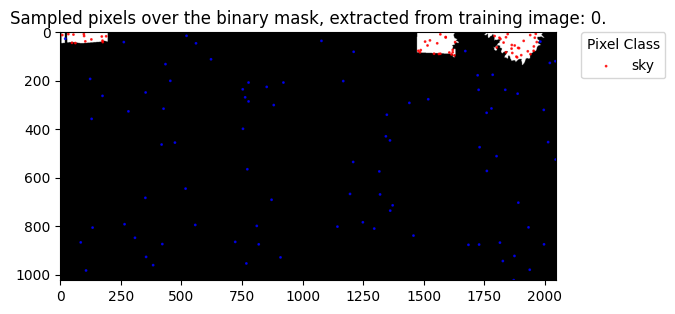

**************************************************
Training dataframe sampled by pixel has 29842 rows and 7 columns.
Training dataframe sampled by pixel has 14928 sky pixels and 14914 non-sky pixel.
Training dataframe sampled by pixel has approximately 85 sky pixels per image and approximately 85 non-sky pixels per image.
Training dataframe sampled by pixel has 174 images.
**************************************************
**************************************************
Testing dataframe sampled by pixel has 9906 rows and 7 columns.
Testing dataframe sampled by pixel has 4957 sky pixels and 4949 non-sky pixel.
Testing dataframe sampled by pixel has approximately 49 sky pixels per image and approximately 49 non-sky pixels per image.
Testing dataframe sampled by pixel has 100 images.
**************************************************
**************************************************
Testing dataframe sampled by pixel has 9889 rows and 7 columns.
Testing dataframe sampled by pixel has

In [25]:
# Sample amount of pixels per class from the training and testing dataset for the pixel classifier:
training_pixels: int = 15000
testing_pixels: int = 5000

# Sample 15000 pixels from the training dataset:
train_pixels_df: pd.DataFrame = pixel_sampler(total_count=training_pixels, train=True)
# Sample 5000 pixels from the validation dataset:
val_pixels_df: pd.DataFrame = validation_pixel_sampler(total_count=testing_pixels)
# Sample 5000 pixels from the testing dataset:
test_pixels_df: pd.DataFrame = pixel_sampler(total_count=testing_pixels, train=False)

# Save the sampled pixels:
train_pixels_df.to_csv(Path(TRAINING_DATASET_PATH, 'train_by_pixel.csv'), index=False)
val_pixels_df.to_csv(Path(VALIDATION_DATASET_PATH, 'val_by_pixel.csv'), index=False)
test_pixels_df.to_csv(Path(TESTING_DATASET_PATH, 'test_by_pixel.csv'), index=False)

# Inspect the sampled pixels:
sampler_visual_inspector(training=True)

# Explore the pixel datasets:
dataset_explorer(dataframe=train_pixels_df, sampling_type="pixel", train=True)
dataset_explorer(dataframe=val_pixels_df, sampling_type="pixel", train=False)
dataset_explorer(dataframe=test_pixels_df, sampling_type="pixel", train=False)

Sample 512x512 patches and create a balanced patches dataset:

In [26]:
# Sample patches from the training and testing dataset for the patch classifier:
train_patches_df = patch_sampler(train=True)
val_patches_df = val_patch_sampler()
test_patches_df = patch_sampler(train=False)

# Save the sampled patches as pickle files to preserve the image data:
train_patches_df.to_pickle(Path(TRAINING_DATASET_PATH, 'train_by_patch.pkl'))
val_patches_df.to_pickle(Path(VALIDATION_DATASET_PATH, 'val_by_patch.pkl'))
test_patches_df.to_pickle(Path(TESTING_DATASET_PATH, 'test_by_patch.pkl'))

# Explore the patch datasets:
dataset_explorer(dataframe=train_patches_df, sampling_type="patch", train=True)
dataset_explorer(dataframe=val_patches_df, sampling_type="patch", train=False)
dataset_explorer(dataframe=test_patches_df, sampling_type="patch", train=False)

Images: 100%|███████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 308.86it/s]


**************************************************
Training dataframe sampled by patch has 390 rows and 6 columns.
Training dataframe sampled by patch has 195 sky patches and 195 non-sky patch.
Training dataframe sampled by patch has 390 patches of size 256x256.
Training dataframe sampled by patch has 65 images.
**************************************************
**************************************************
Testing dataframe sampled by patch has 210 rows and 6 columns.
Testing dataframe sampled by patch has 105 sky patches and 105 non-sky patch.
Testing dataframe sampled by patch has 210 patches of size 256x256.
Testing dataframe sampled by patch has 35 images.
**************************************************
**************************************************
Testing dataframe sampled by patch has 360 rows and 6 columns.
Testing dataframe sampled by patch has 180 sky patches and 180 non-sky patch.
Testing dataframe sampled by patch has 360 patches of size 256x256.
Testing datafr

### Modelling phase

#### Pixel Classifier by pixel average rgb value using simple Logistic Regression and K-nearest neighbors

Utility functions for Pixel Classifier by pixel average rgb value using simple Logistic Regression

In [29]:
def load_dataset(classification_type: str = 'by_pixel', split_type: str = 'train') -> pd.DataFrame:
    """
    Loads the dataset from the path
    @param split_type: the type of split to be loaded. either train, or val, or test.
    @param classification_type: the type of classification from which to load the dataset.
    :return: the dataset
    """
    # Determine the path of the dataset
    name: str = split_type.lower()
    if name == 'train':
        path: Path = TRAINING_DATASET_PATH
    elif name == 'val':
        path: Path = VALIDATION_DATASET_PATH
    elif name == 'test':
        path: Path = TESTING_DATASET_PATH
    else:
        raise ValueError(f'Unknown split type: {split_type}')

    # Determine the type of classification, either by pixel or by patch
    if classification_type == 'by_pixel':
        df = pd.read_csv(Path(path, f'{name}_by_pixel.csv'))
    elif classification_type == 'by_patch':
        # load the pickle file:
        df = pd.read_pickle(Path(path, f'{name}_by_patch.pkl'))
    else:
        raise ValueError(f'Unknown classification type: {classification_type}')

    return df


def create_model(model_type: str = None) -> LogisticRegression or KNeighborsClassifier:
    """
    Creates a model from the dataset
    @param model_type: the type of model to create
    """
    random_seed: int = 42

    if model_type == 'logistic_regression' or type is None:
        # binary classification
        model = LogisticRegression(random_state=random_seed)
    elif model_type == 'knn':
        model = KNeighborsClassifier()
    else:
        raise ValueError(f'Unknown model type: {model_type}')

    return model


def train_model(model: LogisticRegression or KNeighborsClassifier, train: bool = True) \
        -> LogisticRegression or KNeighborsClassifier:
    """
    Trains the model on the dataset
    @param model: the model to train
    @param train: True if the image is from the training dataset, False if it is from the testing dataset
    :return: the trained model
    """
    df = load_dataset(classification_type='by_pixel', split_type='train')
    rgb = df[['r', 'g', 'b']]
    y = df['class']
    # for the initial classifier we only care about the average RGB value of each pixel:
    x = np.array(rgb.mean(axis=1)).reshape(-1, 1)
    model.fit(x, y)
    return model


def evaluate_model(model: LogisticRegression or KNeighborsClassifier) -> float:
    """
    Evaluates the model on the dataset
    @param model: the model to evaluate
    :return: the AUC score of the model
    """
    df = load_dataset(classification_type='by_pixel', split_type='test')
    rgb = df[['r', 'g', 'b']]
    x = np.array(rgb.mean(axis=1)).reshape(-1, 1)
    y = df['class']
    # Evaluate the model on the AUC score:
    auc = roc_auc_score(y, model.predict(x))
    return auc

Create and fit Logistic Regression and K-nearest neighbors models for classifying pixels by average rgb value.

Print and save their AUC scores:

In [30]:
# Create a Logistic regression model
log_reg = create_model(model_type='logistic_regression')
log_reg = train_model(log_reg)

# Create a K-nearest neighbors model
knn = create_model(model_type='knn')
knn = train_model(knn)

# Compute AUC score for both the models
auc_log = evaluate_model(log_reg)
print(f'Logistic Regression AUC: {auc_log}')
auc_knn = evaluate_model(knn)
print(f'KNN AUC: {auc_knn}')

# Ensure the results directory exists:
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)

# Save the results:
results = pd.DataFrame({'model': ['logistic_regression', 'knn'],
                        'val_auc': [auc_log, auc_knn]})
results.to_csv(Path(RESULTS_PATH, 'pixel_classifier_by_average_rgb.csv'), index=False)

Logistic Regression AUC: 0.9513461344486875
KNN AUC: 0.9471987327592787


#### Pixel Classifier by pixel rgb features using simple Logistic Regression and K-nearest neighbors

Utility functions for Pixel Classifier by pixel average rgb value using simple Logistic Regression

In [31]:
def train_model(model: LogisticRegression or KNeighborsClassifier, train: bool = True) \
        -> LogisticRegression or KNeighborsClassifier:
    """
    Trains the model on the dataset
    @param model: the model to train
    @param train: True if the image is from the training dataset, False if it is from the testing dataset
    :return: the trained model
    """
    train = load_dataset(split_type='train')
    rgb = train[['r', 'g', 'b']]
    y_train = train['class']
    # for this second classifier we take the r, g, b values of each pixel as features:
    x_train = np.array(rgb).reshape(-1, 3)
    model.fit(x_train, y_train)
    return model


def evaluate_model(model: LogisticRegression or KNeighborsClassifier) -> float:
    """
    Evaluates the model on the dataset
    @param model: the model to evaluate
    :return: the AUC score of the model
    """
    df = load_dataset(split_type='test')
    rgb = df[['r', 'g', 'b']]
    x_val = np.array(rgb).reshape(-1, 3)
    y_val = df['class']
    y_pred = model.predict_proba(x_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    return auc

Create and fit Logistic Regression and K-nearest neighbors models for classifying pixels by rgb features.

Print and save their AUC scores:

In [32]:
# Create a Logistic regression model
log_reg = create_model(model_type='logistic_regression')
log_reg = train_model(log_reg)

# Create a K-nearest neighbors model
knn = create_model(model_type='knn')
knn = train_model(knn)

# Compute AUC score for both the models
auc_log = evaluate_model(log_reg)
print(f'Logistic Regression test set AUC with RGB as features: {auc_log}')
auc_knn = evaluate_model(knn)
print(f'KNN test set AUC with RBG as features: {auc_knn}')

# Ensure the results directory exists:
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)

# Save the results:
results = pd.DataFrame({'model': ['logistic_regression', 'knn'],
                        'val_auc': [auc_log, auc_knn]})
results.to_csv(Path(RESULTS_PATH, 'pixel_classifier_by_rgb_as_feature.csv'), index=False)

Logistic Regression test set AUC with RGB as features: 0.9926137138469535
KNN test set AUC with RBG as features: 0.9762132630630515


#### Patch segmentation using a Feed-Forward Neural Network

Utility functions for pacth segmentation using a Feed-Forward Neural Network

In [38]:
def create_ffnn_model(nr_neurons_layer_1: int = 512, nr_neurons_layer_2: int = 256, dropout_rate: float = 0.1) -> Sequential:
    """
    Create a feed forward neural network with 2 hidden layers and a sigmoid output layer.
    @param nr_neurons_layer_1: number of neurons in the first hidden layer
    @param nr_neurons_layer_2: number of neurons in the second hidden layer
    @param dropout_rate: dropout rate
    :return: Sequential: the model.
    """

    # Create a fully connected model:
    model = Sequential()
    # the input layer are 369 patches of 512x512 pixels, each with 3 channels (RGB):
    model.add(Flatten(input_shape=(PATCH_SIZE, PATCH_SIZE, 3)))
    # add a dense layer:
    model.add(Dense(nr_neurons_layer_1, activation='relu'))
    # add a dropout layer to prevent over-fitting:
    model.add(Dropout(dropout_rate))
    # second dense layer:
    model.add(Dense(nr_neurons_layer_2, activation='relu'))
    # add a dropout layer to prevent over-fitting:
    model.add(Dropout(dropout_rate))
    # the output layer is a binary mask of 512x512 pixels, 0 for background and 1 for sky:
    model.add(Dense(PATCH_SIZE * PATCH_SIZE, activation='sigmoid'))
    # reshape the output to be a 512x512 mask:
    model.add(Reshape((PATCH_SIZE, PATCH_SIZE, 1)))

    # compile the model:
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

    return model


def visualize_segmentation(image: np.ndarray, generated_segmentation: np.ndarray, binary_mask: np.ndarray,
                           title: str, path: Union[str, Path], save: bool = False) -> None:
    """
    Visualize the segmentation of an image superimposed on the original image.
    show the binary mask on the right.
    @param image: np.ndarray: the original image
    @param generated_segmentation: np.ndarray: the generated segmentation
    @param binary_mask: np.ndarray: the binary mask of the image
    @param title: str: the title of the plot
    @param save: bool: whether to save the plot
    @param path: Path or str: the path to save the plot to
    :return: None, shows the plot and optionally saves it.
    """

    # plot the image and superimpose the segmentation on the left, the segmentation on its own in the center as
    # a subplot and the binary mask on the right as a subplot:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
    ax1.imshow(image, vmin=0, vmax=1)
    ax1.imshow(generated_segmentation, alpha=0.4, vmin=0, vmax=1, cmap='jet')
    # remove the axis:
    ax1.axis('off')
    ax1.set_title('Superimposed segmentation')
    ax2.imshow(generated_segmentation, vmin=0, vmax=1, cmap='gray')
    # remove the axis:
    ax2.axis('off')
    ax2.set_title(f'Generated segmentation')
    ax3.imshow(binary_mask, vmin=0, vmax=1, cmap='gray')
    # remove the axis:
    ax3.axis('off')
    ax3.set_title(f'Original binary mask')

    # set the title of the plot:
    fig.suptitle(title, fontsize=22, y=0.95)
    plt.axis('off')

    # save the plot if required:
    if save:
        plt.savefig(path)

    # show the plot:
    plt.show()

NameError: name 'Sequential' is not defined

Load the train, test and validation sets and put them in the correct format

In [ ]:
# Load training, validation and testing sets
train = load_dataset(classification_type='by_patch', split_type='train')
val = load_dataset(classification_type='by_patch', split_type='val')
test = load_dataset(classification_type='by_patch', split_type='test')

# Preprocess the data:
# get the raw features and labels:
x_train = train['patch']
y_train = train['mask_label']
x_val = val['patch']
y_val = val['mask_label']
x_test = test['patch']
y_test = test['mask_label']

# preprocess the data, convert to float32 and normalize to [0, 1]:
x_train = np.array(x_train.tolist()).reshape((-1, PATCH_SIZE, PATCH_SIZE, 3)).astype(np.float32) / 255
x_val = np.array(x_val.tolist()).reshape((-1, PATCH_SIZE, PATCH_SIZE, 3)).astype(np.float32) / 255
x_test = np.array(x_test.tolist()).reshape((-1, PATCH_SIZE, PATCH_SIZE, 3)).astype(np.float32) / 255
y_train = np.array(y_train.tolist()).reshape((-1, PATCH_SIZE, PATCH_SIZE, 1)).astype(np.float32)
y_val = np.array(y_val.tolist()).reshape((-1, PATCH_SIZE, PATCH_SIZE, 1)).astype(np.float32)
y_test = np.array(y_test.tolist()).reshape((-1, PATCH_SIZE, PATCH_SIZE, 1)).astype(np.float32)

Create, fit and evaluate the Feed-Forward Neural Network:

In [ ]:
# Create the Feed-Forward Neural Network model
ffnn = create_ffnn_model()

# Train the model:
ffnn.fit(x_train, y_train, epochs=10, batch_size=32,
          validation_data=(x_val, y_val), callbacks=[tf.keras.callbacks.TensorBoard(log_dir=log_path)])

# Evaluate the model on the AUC metric:
y_pred = ffnn.predict(x_test)

# Get the categorical predictions from the sigmoid output:
y_pred = np.where(y_pred > 0.5, 1, 0)

# Flatten for the AUC metric:
y_pred_flat = y_pred.ravel()
y_test_flat = y_test.ravel()

# Calculate the AUC:
auc_ff_nn = roc_auc_score(y_test_flat, y_pred_flat)
print(f'The AUC on the test set is: {auc_ff_nn}')

# Ensure the results directory exists:
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)
# Save the results:
results = pd.DataFrame({'model': ['dense'], 'auc': [auc_ff_nn]})
results.to_csv(Path(RESULTS_PATH, 'segmentation_by_patch_classification_feed_forward.csv'), index=False)

# Get 3 random images from the test set:
random_indexes = np.random.choice(range(len(x_test)), 3)
for i in random_indexes:
    # get the image and the segmentation:
    image = x_test[i]
    # get the binary mask:
    binary_mask = y_test[i]
    generated_segmentation = y_pred[i]
    # visualize the image and the segmentation:
    visualize_segmentation(image=image, 
                           generated_segmentation=generated_segmentation, 
                           binary_mask=binary_mask,
                           title=f'Test image {i} segmentation by patch classification', 
                           save=True,
                           path=Path(SAMPLE_IMAGE_RESULTS_PATH,
                                     f'test_image_{i}_segmentation_by_patch_classification_feed_forward.png'))

#### Patch segmentation using a Convolutional Neural Network

Utility functions for pacth segmentation using a Convolutional Neural Network

In [ ]:
def create_cnn_model():
    input_layer = Input(shape=(None, None, 3))
    x = Conv2D(filters=2, kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
    x = Conv2D(filters=4, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=128, kernel_size=(1, 1), padding='same', activation='relu')(x)
    x = Conv2D(filters=1, kernel_size=(1, 1), padding='same', activation='sigmoid')(x)
    return Model(input_layer, x)

Create, fit and evaluate the Convolutional Neural Network:

In [ ]:
# Create the Convolutional Neural Network model
model = create_cnn_model()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# Train the model
model.fit(x_train, y_train, epochs=3, batch_size=32,
          validation_data=(x_validation, y_validation),
          callbacks=[tf.keras.callbacks.TensorBoard(log_dir=str(log_path), histogram_freq=1)])

# Evaluate the model:
y_pred = model.predict(x_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

# Flatten for the AUC metric:
y_pred_flat = y_pred.ravel()
y_test_flat = y_test.ravel()

# Calculate the AUC:
auc_cnn_unet = roc_auc_score(y_test_flat, y_pred_flat)
print(f'The AUC on the test set is: {auc_cnn_unet}')

# Save the results:
results_path = Path(RESULTS_PATH)
results_path.mkdir(parents=True, exist_ok=True)
results = pd.DataFrame({'auc': [auc_cnn_unet]})
results_path /= 'auc_cnn_unet.csv'
results.to_csv(results_path, index=False)

#### Patch segmentation using a Feed-Forward Neural Network

Utility functions for pacth segmentation using a U-Net Convolutional Neural Network

In [ ]:
def create_unet_cnn_model() -> Model:
    """
    Creates a U-Net model, copied from professor Giusti's jupyter notebook fcn.ipynb.
    @return: Model, the U-Net model.
    """
    input_layer = Input(shape=(None, None, 3), name='input')
    x = Conv2D(filters=4, kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
    x = BatchNormalization()(x)
    x = SeparableConv2D(filters=8, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x1 = x
    x = MaxPooling2D(2)(x)
    x = SeparableConv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x2 = x
    x = MaxPooling2D(2)(x)
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(2)(x)
    x = Concatenate()([x, x2]) # Skip connections
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(2)(x)
    x = Concatenate()([x, x1])  # Skip connections
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=128, kernel_size=(1, 1), padding='same', activation='relu')(x)
    x = Conv2D(filters=1, kernel_size=(1, 1), padding='same', activation='sigmoid')(x)
    return Model(input_layer, x)

Create, fit and evaluate the U-Net Convolutional Neural Network:

In [ ]:
# Create the U-Net Convolutional Neural Network model
model = create_unet_cnn_model()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# Train the model
model.fit(x_train, y_train, epochs=5, batch_size=128,
          validation_data=(x_validation, y_validation),
          callbacks=[tf.keras.callbacks.TensorBoard(log_dir=str(log_path), histogram_freq=1)])

# Evaluate the model:
y_pred = model.predict(x_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

# Flatten for the AUC metric:
y_pred_flat = y_pred.ravel()
y_test_flat = y_test.ravel()

# Calculate the AUC:
auc_cnn_unet = roc_auc_score(y_test_flat, y_pred_flat)
print(f'The AUC on the test set is: {auc_cnn_unet}')

# Save the results:
results_path = Path(RESULTS_PATH)
results_path.mkdir(parents=True, exist_ok=True)
results = pd.DataFrame({'auc': [auc_cnn_unet]})
results_path /= 'auc_cnn_unet.csv'
results.to_csv(results_path, index=False)